# make the ICU OLR anomalies maps

[Nicolas Fauchereau](mailto:nicolas.fauchereau@gmail.com)

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap

In [13]:
import os, sys
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import monthdelta

In [5]:
sys.path.append(os.path.join(os.environ['HOME'], "pythonlibs/"))
import colormaps_functions as cf

In [6]:
from netCDF4 import Dataset

### defines the plotting function

In [26]:
def plot_OLR_ICU_anomalies(data, vmin, vmax, step, date):
    ### ==============================================================================================================
    title = "OLR anomalies for {}".format(date.strftime("%Y/%m"))
    ### plot for anomalies     
    fig = plt.figure(figsize=(9.5,4.9))
    ax = fig.add_axes([0.03,0.05,0.92,0.9])
    m = Basemap(projection='cyl', llcrnrlon=ll_lon, llcrnrlat=ll_lat, urcrnrlon=ur_lon, urcrnrlat=ur_lat, resolution='h', ax=ax, area_thresh=10.)
    
    im = m.imshow(data,origin='upper',interpolation='nearest',cmap=cf.gmtColormap('purple-orange'),vmin=-90,vmax=90)
    
    cb = m.colorbar(im,ticks=np.arange(vmin, vmax+step,step),boundaries=np.arange(vmin,vmax+step,step), drawedges=True)

    cb.ax.set_yticklabels([str(ll).rjust(4," ") for  ll in np.arange(vmin,vmax+step,step)])
    cb.set_label("$W.m^{-2}$", fontsize=16)
    for t in cb.ax.get_yticklabels():
        t.set_fontsize(12)
        t.set_color('k')
        t.set_ha('left')

    im = m.contour(lons, lats, data, np.arange(-90,0,10), linewidth=0.2, alpha=0.8, colors='b', linestyles='solid', latlon=True)
    plt.clabel(im, fmt = '%1.0f', fontsize = 12, alpha=0.8, colors='k')
    im = m.contour(lons, lats, data, np.arange(10,90+10,10), linewidth=0.2, alpha=0.8, colors='r', linestyles='solid', latlon=True)
    plt.clabel(im, fmt = '%1.0f', fontsize = 12, alpha=0.8, colors='k')
    m.contour(lons, lats, data, 0, alpha=0.8, colors='w', linewidth=2, latlon=True)

    # draw the coastlines
    m.drawcoastlines(linewidth=1.)

    #draw parallels and meridians.
    delat = 10.
    circles = np.arange(ll_lat, ur_lat + delat, delat)
    m.drawparallels(circles, labels=[1,0,0,0], fontsize=14, linewidth=0.8, alpha=0.8)
    delon = 20.
    meridians = np.arange(ll_lon, ur_lon, delon)
    m.drawmeridians(meridians, labels=[0,0,0,1], fontsize=14, linewidth=0.8, alpha=0.8)
    plt.title(title, fontsize=16)

### set up the proxies so that python can access dods if run by CRON

In [8]:
#os.environ['http_proxy'] = 'http://proxy_url:port'

### path to save the figures

In [9]:
fpath = os.path.join(os.environ['HOME'], 'operational/ICU/supplement/OLR/figures/')

### last month

In [10]:
date = datetime.utcnow() - monthdelta.monthdelta(1)

### set up domain

In [14]:
ll_lon = 135. 
ll_lat = -50.
ur_lon = 240.
ur_lat = 10.

### get the data through DODS

In [15]:
with Dataset("http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/.CPC/.GLOBAL/.monthly/.olr/dods") as nc: 
    lat = nc.variables['Y'][:]
    lon = nc.variables['X'][:]
    ilat = np.where(( (lat >= ll_lat) & (lat <= ur_lat) ))[0]
    ilon = np.where(( (lon >= ll_lon) & (lon <= ur_lon) ))[0] 
    olr = nc.variables['olr'][:,ilat,ilon]
    lon = lon[ilon]
    lat = lat[ilat]
    time = nc.variables['T'][:]

In [17]:
time = pd.period_range(start='1974-06-15', periods=len(time), freq='1M')

### transform into a Pandas DataFrame

In [18]:
olrdf = pd.DataFrame(olr.reshape( (len(time), len(lat) * len(lon) ), order='F'), index=time)

In [19]:
olrdf = olrdf.ix['1979':]

### calculates the anomalies WRT 1981 - 2000 normal

In [20]:
def demean(x): 
    return x - x.ix['1981':'2010'].mean()

In [21]:
olrdf_anoms = olrdf.groupby(olrdf.index.month).transform(demean)

### get the last month anomalies

In [22]:
latest = olrdf_anoms.iloc[-1,:].reshape( (len(lat), len(lon) ), order='F')

In [23]:
lons, lats = np.meshgrid(lon, lat)

### plots

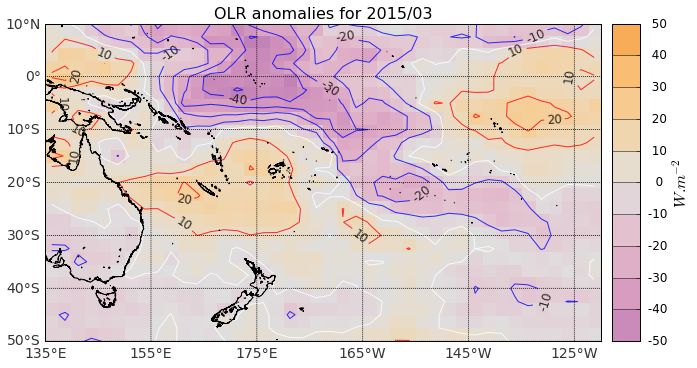

In [27]:
plot_OLR_ICU_anomalies(latest, -50, 50, 10, date)

In [28]:
fname = "anoms_OLR_{}.png".format(date.strftime("%Y%m"))

### saves the figure

In [29]:
plt.savefig(os.path.join(fpath,fname), dpi=200)